In [1]:
import numpy as np
import torch
from sklearn.datasets import make_regression 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

**Module** is an abstract class which defines fundamental methods necessary for a training a neural network. You do not need to change anything here, just read the comments.

In [3]:
class Module(object):
    """
    Basically, you can think of a module as of a something (black box)
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`:

        output = module.forward(input)

    The module should be able to perform a backward pass: to differentiate the `forward` function.
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule.

        gradInput = module.backward(input, gradOutput)
    """
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True

    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        """
        Performs a backpropagation step through the module, with respect to the given input.

        This includes
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput


    def updateOutput(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which is stored in the `output` field.

        Make sure to both store the data in `output` field and return it.
        """

        # The easiest case:

        # self.output = input
        # return self.output

        pass

    def updateGradInput(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own input.
        This is returned in `gradInput`. Also, the `gradInput` state variable is updated accordingly.

        The shape of `gradInput` is always the same as the shape of `input`.

        Make sure to both store the gradients in `gradInput` field and return it.
        """

        # The easiest case:

        # self.gradInput = gradOutput
        # return self.gradInput

        pass

    def accGradParameters(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass

    def zeroGradParameters(self):
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass

    def getParameters(self):
        """
        Returns a list with its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def getGradParameters(self):
        """
        Returns a list with gradients with respect to its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True

    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Module"

# Sequential container

**Define** a forward and backward pass procedures.

In [6]:
class Sequential(Module):
    """
         This class implements a container, which processes `input` data sequentially.

         `input` is processed by each module (layer) in self.modules consecutively.
         The resulting array is called `output`.
    """

    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []
        self.layer_inputs = []

    def add(self, module):
        """
        Adds a module to the container.
        """
        self.modules.append(module)

    def updateOutput(self, input):
        """
        Basic workflow of FORWARD PASS:

            y_0    = module[0].forward(input)
            y_1    = module[1].forward(y_0)
            ...
            output = module[n-1].forward(y_{n-2})


        Just write a little loop.
        """
        # Your code goes here. ################################################
        self.layer_inputs = [input] 
        current_input = input
        for module in self.modules:
            current_input = module.forward(current_input)
            self.layer_inputs.append(current_input)  
        self.output = current_input
        return self.output

    def backward(self, input, gradOutput):
        """
        Workflow of BACKWARD PASS:

            g_{n-1} = module[n-1].backward(y_{n-2}, gradOutput)
            g_{n-2} = module[n-2].backward(y_{n-3}, g_{n-1})
            ...
            g_1 = module[1].backward(y_0, g_2)
            gradInput = module[0].backward(input, g_1)


        !!!

        To ech module you need to provide the input, module saw while forward pass,
        it is used while computing gradients.
        Make sure that the input for `i-th` layer the output of `module[i]` (just the same input as in forward pass)
        and NOT `input` to this Sequential module.

        !!!

        """
        # Your code goes here. ################################################
        current_grad = gradOutput
        for i in range(len(self.modules)-1, -1, -1):
            module = self.modules[i]
            module_input = self.layer_inputs[i] 
            current_grad = module.backward(module_input, current_grad)
        self.gradInput = current_grad
        
        return self.gradInput


    def zeroGradParameters(self):
        for module in self.modules:
            module.zeroGradParameters()

    def getParameters(self):
        """
        Should gather all parameters in a list.
        """
        return [x.getParameters() for x in self.modules]

    def getGradParameters(self):
        """
        Should gather all gradients w.r.t parameters in a list.
        """
        return [x.getGradParameters() for x in self.modules]

    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string

    def __getitem__(self,x):
        return self.modules.__getitem__(x)

    def train(self):
        """
        Propagates training parameter through all modules
        """
        self.training = True
        for module in self.modules:
            module.train()

    def evaluate(self):
        """
        Propagates training parameter through all modules
        """
        self.training = False
        for module in self.modules:
            module.evaluate()

# Layers

## 1 (0.2). Linear transform layer
Also known as dense layer, fully-connected layer, FC-layer, InnerProductLayer (in caffe), affine transform
- input:   **`batch_size x n_feats1`**
- output: **`batch_size x n_feats2`**

In [9]:
class Linear(Module):
    """
    A module which applies a linear transformation
    A common name is fully-connected layer, InnerProductLayer in caffe.

    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()

        # This is a nice initialization
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)

        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def updateOutput(self, input):
        # Your code goes here. ################################################
        # self.output = ...
        self.output = np.dot(input, self.W.T) + self.b
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        # self.gradInput = ...
        self.gradInput = np.dot(gradOutput, self.W)
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        # Your code goes here. ################################################
        # self.gradW = ... ; self.gradb = ...
        self.gradW += np.dot(gradOutput.T, input)
        self.gradb += gradOutput.sum(axis=0)
        pass

    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

## 2. (0.2) SoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{softmax}(x)_i = \frac{\exp x_i} {\sum_j \exp x_j}$

Recall that $\text{softmax}(x) == \text{softmax}(x - \text{const})$. It makes possible to avoid computing exp() from large argument.

In [11]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()

    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))

        # Your code goes here. ################################################
        self.output = np.exp(self.output) / np.sum(np.exp(self.output), axis=1, keepdims=True)
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        sum_SM = np.sum(self.output * gradOutput, axis=1, keepdims=True)
        self.gradInput = self.output * (gradOutput - sum_SM)
        return self.gradInput

    def __repr__(self):
        return "SoftMax"

## 3. (0.2) LogSoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{logsoftmax}(x)_i = \log\text{softmax}(x)_i = x_i - \log {\sum_j \exp x_j}$

The main goal of this layer is to be used in computation of log-likelihood loss.

In [13]:
class LogSoftMax(Module):
    def __init__(self):
         super(LogSoftMax, self).__init__()

    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))

        # Your code goes here. ################################################
        self.output -= np.log(np.sum(np.exp(self.output), axis=1, keepdims=True))
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################

        self.gradInput = gradOutput - np.exp(self.output) * np.sum(gradOutput, axis=1, keepdims=True)
        return self.gradInput

    def __repr__(self):
        return "LogSoftMax"

## 4. (0.3) Batch normalization
One of the most significant recent ideas that impacted NNs a lot is [**Batch normalization**](http://arxiv.org/abs/1502.03167). The idea is simple, yet effective: the features should be whitened ($mean = 0$, $std = 1$) all the way through NN. This improves the convergence for deep models letting it train them for days but not weeks. **You are** to implement the first part of the layer: features normalization. The second part (`ChannelwiseScaling` layer) is implemented below.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

The layer should work as follows. While training (`self.training == True`) it transforms input as $$y = \frac{x - \mu}  {\sqrt{\sigma + \epsilon}}$$
where $\mu$ and $\sigma$ - mean and variance of feature values in **batch** and $\epsilon$ is just a small number for numericall stability. Also during training, layer should maintain exponential moving average values for mean and variance:
```
    self.moving_mean = self.moving_mean * alpha + batch_mean * (1 - alpha)
    self.moving_variance = self.moving_variance * alpha + batch_variance * (1 - alpha)
```
During testing (`self.training == False`) the layer normalizes input using moving_mean and moving_variance.

Note that decomposition of batch normalization on normalization itself and channelwise scaling here is just a common **implementation** choice. In general "batch normalization" always assumes normalization + scaling.

In [15]:
class BatchNormalization(Module):
    EPS = 1e-3
    def __init__(self, alpha = 0.):
        super(BatchNormalization, self).__init__()
        self.alpha = alpha
        self.moving_mean = None
        self.moving_variance = None

    def updateOutput(self, input):
        # Your code goes here. ################################################
        # use self.EPS please
        if self.training:
            mean = np.mean(input, axis=0)
            variance = np.var(input, axis=0)
            self.output = (input - mean) / np.sqrt(variance + self.EPS)
            if self.moving_mean is None:
                self.moving_mean = mean
                self.moving_variance = variance
            else:
                self.moving_mean = self.moving_mean * self.alpha + mean * (1 - self.alpha)
                self.moving_variance = self.moving_variance * self.alpha + variance * (1 - self.alpha)
        else:
            assert self.moving_mean is not None and self.moving_variance is not None
            self.output = (input - self.moving_mean) / np.sqrt(self.moving_variance + self.EPS)
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        if self.training:
            mean = np.mean(input, axis=0)
            variance = np.var(input, axis=0)
            n = input.shape[0]
            dvar = np.sum(gradOutput * (input - mean) * (-0.5) * 
                     (variance + self.EPS)**(-1.5), axis=0)
        
            dmean = np.sum(gradOutput * (-1) / np.sqrt(variance + self.EPS), axis=0) + \
                   dvar * (-2) * np.mean(input - mean, axis=0)
        
            self.gradInput = (gradOutput / np.sqrt(variance + self.EPS) +
                         dvar * 2 * (input - mean) / n +
                         dmean / n)
        else:
            self.gradInput = gradOutput / np.sqrt(self.moving_variance + self.EPS)
        
        return self.gradInput

    def __repr__(self):
        return "BatchNormalization"

In [16]:
class ChannelwiseScaling(Module):
    """
       Implements linear transform of input y = \gamma * x + \beta
       where \gamma, \beta - learnable vectors of length x.shape[-1]
    """
    def __init__(self, n_out):
        super(ChannelwiseScaling, self).__init__()

        stdv = 1./np.sqrt(n_out)
        self.gamma = np.random.uniform(-stdv, stdv, size=n_out)
        self.beta = np.random.uniform(-stdv, stdv, size=n_out)

        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)

    def updateOutput(self, input):
        self.output = input * self.gamma + self.beta
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.gamma
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        self.gradBeta = np.sum(gradOutput, axis=0)
        self.gradGamma = np.sum(gradOutput*input, axis=0)

    def zeroGradParameters(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)

    def getParameters(self):
        return [self.gamma, self.beta]

    def getGradParameters(self):
        return [self.gradGamma, self.gradBeta]

    def __repr__(self):
        return "ChannelwiseScaling"

Practical notes. If BatchNormalization is placed after a linear transformation layer (including dense layer, convolutions, channelwise scaling) that implements function like `y = weight * x + bias`, than bias adding become useless and could be omitted since its effect will be discarded while batch mean subtraction. If BatchNormalization (followed by `ChannelwiseScaling`) is placed before a layer that propagates scale (including ReLU, LeakyReLU) followed by any linear transformation layer than parameter `gamma` in `ChannelwiseScaling` could be freezed since it could be absorbed into the linear transformation layer.

## 5. (0.3) Dropout
Implement [**dropout**](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). The idea and implementation is really simple: just multimply the input by $Bernoulli(p)$ mask. Here $p$ is probability of an element to be zeroed.

This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons.

While training (`self.training == True`) it should sample a mask on each iteration (for every batch), zero out elements and multiply elements by $1 / (1 - p)$. The latter is needed for keeping mean values of features close to mean values which will be in test mode. When testing this module should implement identity transform i.e. `self.output = input`.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

In [19]:
class Dropout(Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()

        self.p = p
        self.mask = None

    def updateOutput(self, input):
        # Your code goes here. ################################################
        if self.training:
            self.mask = (np.random.rand(*input.shape) > self.p).astype(float)
            self.output = input * self.mask / (1.0 - self.p)
        else:
            self.output = input
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        if self.training:
            self.gradInput = gradOutput * self.mask / (1.0 - self.p)
        else:
            self.gradInput = gradOutput
        return self.gradInput

    def __repr__(self):
        return "Dropout"

#6. (2.0) Conv2d
Implement [**Conv2d**](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). Use only this list of parameters: (in_channels, out_channels, kernel_size, stride, padding, bias, padding_mode) and fix dilation=1 and groups=1.

In [21]:
class Conv2d(Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, bias=True, padding_mode='zeros'):
        super(Conv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.bias = bias
        self.padding_mode = padding_mode

    def updateOutput(self, input):
        # Your code goes here. ################################################
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        return self.gradInput

    def __repr__(self):
        return "Conv2d"

#7. (0.5) Implement [**MaxPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) and [**AvgPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html). Use only parameters like kernel_size, stride, padding (negative infinity for maxpool and zero for avgpool) and other parameters fixed as in framework.

In [23]:
class MaxPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(MaxPool2d, self).__init__()

        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def updateOutput(self, input):
        # Your code goes here. ################################################
        if isinstance(input, np.ndarray):
            input = torch.from_numpy(input)
        padded_input = torch.nn.functional.pad(input, (self.padding, self.padding, self.padding, self.padding), 
                                              mode='constant', value=-float('inf'))
        batch_size, channels, H_in, W_in = input.shape
        H_out = (H_in + 2*self.padding - self.kernel_size) // self.stride + 1
        W_out = (W_in + 2*self.padding - self.kernel_size) // self.stride + 1
        self.output = torch.zeros(batch_size, channels, H_out, W_out) 
        self.max_indices = torch.zeros_like(self.output, dtype=torch.long)
        
        for i in range(batch_size):
            for j in range(channels):
                for n in range(H_out):
                    for m in range(W_out):
                        H_start = n * self.stride
                        H_end = H_start + self.kernel_size
                        W_start = m * self.stride
                        W_end = W_start + self.kernel_size
                        
                        window = padded_input[i, j, H_start:H_end, W_start:W_end]
                        self.output[i, j, n, m] = torch.max(window)
                        self.max_indices[i, j, n, m] = torch.argmax(window)
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        if isinstance(input, np.ndarray):
            input = torch.from_numpy(input)
        if isinstance(gradOutput, np.ndarray):
            gradOutput = torch.from_numpy(gradOutput)
        batch_size, channels, H_in, W_in = input.shape
        H_out, W_out = gradOutput.shape[-2:]
        self.gradInput = torch.zeros_like(input)
        padded_input = torch.nn.functional.pad(input, 
                                             (self.padding, self.padding, self.padding, self.padding), 
                                             mode='constant', value=-float('inf'))
        
        for i in range(batch_size):
            for j in range(channels):
                for n in range(H_out):
                    for m in range(W_out):
                        H_start = n * self.stride
                        W_start = m * self.stride
                        
                        idx = self.max_indices[i, j, n, m]
                        kh = idx // self.kernel_size
                        kw = idx % self.kernel_size
                        
                        if (H_start + kh < H_in + 2*self.padding and 
                            W_start + kw < W_in + 2*self.padding):
                            self.gradInput[i, j, H_start + kh - self.padding, 
                                          W_start + kw - self.padding] += gradOutput[i, j, n, m]
        
        return self.gradInput

    def __repr__(self):
        return "MaxPool2d"

class AvgPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(AvgPool2d, self).__init__()

        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def updateOutput(self, input):
        # Your code goes here. ################################################
        if isinstance(input, np.ndarray):
            input = torch.from_numpy(input)     
        padded_input = torch.nn.functional.pad(input,
                                             (self.padding, self.padding, self.padding, self.padding),
                                             mode='constant', value=0)
        
        batch_size, channels, H_in, W_in = input.shape
        H_out = (H_in + 2*self.padding - self.kernel_size) // self.stride + 1
        W_out = (W_in + 2*self.padding - self.kernel_size) // self.stride + 1
        
        self.output = torch.zeros(batch_size, channels, H_out, W_out)
        for i in range(batch_size):
            for j in range(channels):
                for n in range(H_out):
                    for m in range(W_out):
                        H_start = n * self.stride
                        H_end = H_start + self.kernel_size
                        W_start = m * self.stride
                        W_end = W_start + self.kernel_size
                        
                        window = padded_input[i, j, H_start:H_end, W_start:W_end]
                        self.output[i, j, n, m] = torch.mean(window)
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        if isinstance(input, np.ndarray):
            input = torch.from_numpy(input)
        if isinstance(gradOutput, np.ndarray):
            gradOutput = torch.from_numpy(gradOutput)
            
        batch_size, channels, H_in, W_in = input.shape
        H_out, W_out = gradOutput.shape[-2:]
        self.gradInput = torch.zeros_like(input)
        scale = 1.0 / (self.kernel_size * self.kernel_size)
        
        for i in range(batch_size):
            for j in range(channels):
                for n in range(H_out):
                    for m in range(W_out):
                        H_start = n * self.stride
                        H_end = H_start + self.kernel_size
                        W_start = m * self.stride
                        W_end = W_start + self.kernel_size
                        
                        grad_val = gradOutput[i, j, n, m] * scale
                        self.gradInput[i, j, max(0, H_start - self.padding):min(H_in, H_end - self.padding),
                                     max(0, W_start - self.padding):min(W_in, W_end - self.padding)] += grad_val
        
        return self.gradInput

    def __repr__(self):
        return "AvgPool2d"

#8. (0.3) Implement **GlobalMaxPool2d** and **GlobalAvgPool2d**. They do not have testing and parameters are up to you but they must aggregate information within channels. Write test functions for these layers on your own.

In [25]:
class GlobalMaxPool2d(Module):
    def __init__(self):
        super(GlobalMaxPool2d, self).__init__()
        
    def updateOutput(self, input):
        self.output = torch.max(torch.max(input, dim=-1)[0], dim=-1)[0].unsqueeze(-1).unsqueeze(-1)
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = torch.zeros_like(input)
        
        max_vals_h = torch.max(input, dim=-1)[0]  
        max_vals = torch.max(max_vals_h, dim=-1)[0]
        mask = (input == max_vals.unsqueeze(-1).unsqueeze(-1)).float()
        
        norm = mask.sum(dim=[-1,-2], keepdim=True)
        mask = mask / (norm + 1e-10)
        
        self.gradInput = mask * gradOutput
        return self.gradInput
    
    def __repr__(self):
        return "GlobalMaxPool2d()"

#9. (0.2) Implement [**Flatten**](https://pytorch.org/docs/stable/generated/torch.flatten.html)

In [27]:
class Flatten(Module):
    def __init__(self, start_dim=0, end_dim=-1):
        super(Flatten, self).__init__()

        self.start_dim = start_dim
        self.end_dim = end_dim

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.original_shape = input.shape
        if self.end_dim < 0:
            self.end_dim = len(self.original_shape) + self.end_dim
        new_shape = list(self.original_shape[:self.start_dim])
        flattened_size = 1
        for dim in self.original_shape[self.start_dim:self.end_dim+1]:
            flattened_size *= dim
        new_shape.append(flattened_size)
        new_shape.extend(self.original_shape[self.end_dim+1:])
        self.output = input.reshape(new_shape)
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = gradOutput.reshape(self.original_shape)
        return self.gradInput

    def __repr__(self):
        return "Flatten"

# Activation functions

Here's the complete example for the **Rectified Linear Unit** non-linearity (aka **ReLU**):

In [30]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()

    def updateOutput(self, input):
        self.output = np.maximum(input, 0)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput , input > 0)
        return self.gradInput

    def __repr__(self):
        return "ReLU"

## 10. (0.1) Leaky ReLU
Implement [**Leaky Rectified Linear Unit**](http://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29%23Leaky_ReLUs). Expriment with slope.

In [32]:
class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()

        self.slope = slope

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.maximum(input, self.slope * input)
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.where(input > 0, gradOutput, gradOutput * self.slope)
        return self.gradInput

    def __repr__(self):
        return "LeakyReLU"

## 11. (0.1) ELU
Implement [**Exponential Linear Units**](http://arxiv.org/abs/1511.07289) activations.

In [34]:
class ELU(Module):
    def __init__(self, alpha = 1.0):
        super(ELU, self).__init__()

        self.alpha = alpha

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.where(input > 0, input, self.alpha*(np.exp(input)-1))
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.where(input > 0, gradOutput, gradOutput * self.alpha * np.exp(input))
        return self.gradInput

    def __repr__(self):
        return "ELU"

## 12. (0.1) SoftPlus
Implement [**SoftPlus**](https://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29) activations. Look, how they look a lot like ReLU.

In [36]:
class SoftPlus(Module):
    def __init__(self):
        super(SoftPlus, self).__init__()

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.log(1 + np.exp(input))
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################  # Handle large negative values
        self.gradInput = gradOutput * (1 / (1 + np.exp(-input)))
        return self.gradInput

    def __repr__(self):
        return "SoftPlus"

#13. (0.2) Gelu
Implement [**Gelu**](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) activations.

In [38]:
class Gelu(Module):
    def __init__(self):
        super(Gelu, self).__init__()

    def updateOutput(self, input):
        # Your code goes here. ################################################\
        self.output = 0.5 * input * (1 + torch.erf(torch.from_numpy(input / np.sqrt(2))).numpy())
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = gradOutput * (0.5*(1 + torch.erf(torch.from_numpy(input/np.sqrt(2))).numpy()) + (input * np.exp(-0.5*input**2))/np.sqrt(2*np.pi))
        return self.gradInput

    def __repr__(self):
        return "Gelu"

# Criterions

Criterions are used to score the models answers.

In [41]:
class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None

    def forward(self, input, target):
        """
            Given an input and a target, compute the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateOutput`.
        """
        return self.updateOutput(input, target)

    def backward(self, input, target):
        """
            Given an input and a target, compute the gradients of the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateGradInput`.
        """
        return self.updateGradInput(input, target)

    def updateOutput(self, input, target):
        """
        Function to override.
        """
        return self.output

    def updateGradInput(self, input, target):
        """
        Function to override.
        """
        return self.gradInput

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Criterion"

The **MSECriterion**, which is basic L2 norm usually used for regression, is implemented here for you.
- input:   **`batch_size x n_feats`**
- target: **`batch_size x n_feats`**
- output: **scalar**

In [43]:
class MSECriterion(Criterion):
    def __init__(self):
        super(MSECriterion, self).__init__()

    def updateOutput(self, input, target):
        self.output = np.sum(np.power(input - target,2)) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        self.gradInput  = (input - target) * 2 / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "MSECriterion"

## 14. (0.2) Negative LogLikelihood criterion (numerically unstable)
You task is to implement the **ClassNLLCriterion**. It should implement [multiclass log loss](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss). Nevertheless there is a sum over `y` (target) in that formula,
remember that targets are one-hot encoded. This fact simplifies the computations a lot. Note, that criterions are the only places, where you divide by batch size. Also there is a small hack with adding small number to probabilities to avoid computing log(0).
- input:   **`batch_size x n_feats`** - probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**



In [45]:
class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15
    def __init__(self):
        a = super(ClassNLLCriterionUnstable, self)
        super(ClassNLLCriterionUnstable, self).__init__()

    def updateOutput(self, input, target):
        # return loss of loss function

        # Use this trick to avoid numerical errors
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)

        # Your code goes here. ################################################
        self.output = -np.sum(target * np.log(input_clamp)) / target.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        # return gradient of loss function

        # Use this trick to avoid numerical errors
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)

        # Your code goes here. ################################################
        self.gradInput = -target / (input_clamp * target.shape[0])
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterionUnstable"

## 15. (0.3) Negative LogLikelihood criterion (numerically stable)
- input:   **`batch_size x n_feats`** - log probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**

Task is similar to the previous one, but now the criterion input is the output of log-softmax layer. This decomposition allows us to avoid problems with computation of forward and backward of log().

In [47]:
class ClassNLLCriterion(Criterion):
    def __init__(self):
        a = super(ClassNLLCriterion, self)
        super(ClassNLLCriterion, self).__init__()

    def updateOutput(self, input, target):
        # Your code goes here. ################################################
        self.output = -np.sum(target * input) / target.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        # Your code goes here. ################################################
        self.gradInput = -target / target.shape[0]
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterion"

1-я часть задания: реализация слоев, лосей и функций активации - 5 баллов. \\
2-я часть задания: реализация моделей на своих классах. Что должно быть:
  1. Выберите оптимизатор и реализуйте его, чтоб он работал с вами классами. - 1 балл.
  2. Модель для задачи мультирегрессии на выбраных вами данных. Использовать FCNN, dropout, batchnorm, MSE. Пробуйте различные фукнции активации. Для первой модели попробуйте большую, среднюю и маленькую модель. - 1 балл.
  3. Модель для задачи мультиклассификации на MNIST. Использовать свёртки, макспулы, флэттэны, софтмаксы - 1 балла.
  4. Автоэнкодер для выбранных вами данных. Должен быть на свёртках и полносвязных слоях, дропаутах, батчнормах и тд. - 2 балла. \\

Дополнительно в оценке каждой модели будет учитываться:
1. Наличие правильно выбранной метрики и лосс функции.
2. Отрисовка графиков лосей и метрик на трейне-валидации. Проверка качества модели на тесте.
3. Наличие шедулера для lr.
4. Наличие вормапа. 
5. Наличие механизма ранней остановки и сохранение лучшей модели.
6. Свитч лося (метрики) и оптимайзера.

In [49]:
class AdamOptimizer:
    def __init__(self, model, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.model = model
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0
        self.params = self._flatten(model.getParameters())
        self.grads = []
        self.m = [np.zeros_like(p) for p in self.params]
        self.v = [np.zeros_like(p) for p in self.params]

    def _flatten(self, params):
        flat = []
        for item in params:
            if isinstance(item, (list, tuple)):
                flat.extend(self._flatten(item))
            elif isinstance(item, np.ndarray):
                flat.append(item)
            else:
                raise ValueError(f"Неподдерживаемый тип: {type(item)}")
        return flat

    def step(self):
        self.t += 1
        self.grads = self._flatten(self.model.getGradParameters())
        
        for i in range(len(self.params)):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * self.grads[i]
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (self.grads[i] ** 2)
            m_hat = self.m[i] / (1 - self.beta1**self.t)
            v_hat = self.v[i] / (1 - self.beta2**self.t)
            self.params[i][...] -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

In [50]:
n_samples=30000
n_features=18
n_targets=3
noise=0.1
X, y = make_regression(n_samples=n_samples, n_features=n_features, n_targets=n_targets, noise=noise, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
mean, std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

In [51]:
class LRScheduler:
    def __init__(self, optimizer, patience=5, factor=0.1):
        self.optimizer = optimizer
        self.patience = patience
        self.factor = factor
        self.best_loss = float('inf')
        self.counter = 0
        
    def step(self, current_loss):
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.optimizer.lr *= self.factor
                self.counter = 0
                print(f"Learning rate reduced to {self.optimizer.lr}")

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.best_params = None

    def _flatten_params(self, params):
        flat = []
        for item in params:
            if isinstance(item, (list, tuple)):
                flat.extend(self._flatten_params(item))
            elif isinstance(item, np.ndarray):
                flat.append(item.copy())  
            else:
                raise ValueError(f"Unsupported parameter type: {type(item)}")
        return flat

    def __call__(self, model, current_loss):
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
            self.best_params = self._flatten_params(model.getParameters())
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                current_params = self._flatten_params(model.getParameters())
                for i, p in enumerate(self.best_params):
                    current_params[i][...] = p  
                return True
            return False

    def _flatten_params(self, params):
        flat = []
        for item in params:
            if isinstance(item, (list, tuple)):
                flat.extend(self._flatten_params(item))
            elif isinstance(item, np.ndarray):
                flat.append(item)
            else:
                raise ValueError(f"Unsupported parameter type: {type(item)}")
        return flat

    def __call__(self, model, current_loss):
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
            self.best_params = self._flatten_params(model.getParameters())
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                current_params = self._flatten_params(model.getParameters())
                for i, p in enumerate(self.best_params):
                    current_params[i][...] = p
                return True
            return False

def plot_metrics(train_loss, val_loss, title="Training Metrics"):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid()
    plt.show()

def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=128, lr=0.001):
    criterion = MSECriterion()
    optimizer = AdamOptimizer(model, lr=lr)
    lr_scheduler = LRScheduler(optimizer)
    early_stopping = EarlyStopping()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        permutation = np.random.permutation(len(X_train))
        batch_losses = []
        
        for i in range(0, len(X_train), batch_size):
            indices = permutation[i:i+batch_size]
            X_batch = X_train[indices]
            y_batch = y_train[indices]
            output = model.forward(X_batch)
            loss = criterion.forward(output, y_batch)
            grad = criterion.backward(output, y_batch)
            model.backward(X_batch, grad)
            optimizer.step()
            model.zeroGradParameters()
            batch_losses.append(loss)
        
        train_loss = np.mean(batch_losses)
        train_losses.append(train_loss)
        model.evaluate()
        val_output = model.forward(X_val)
        val_loss = criterion.forward(val_output, y_val)
        val_losses.append(val_loss)
        
        lr_scheduler.step(val_loss)
        if early_stopping(model, val_loss):
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    plot_metrics(train_losses, val_losses)
    return train_losses, val_losses

Epoch 1/100 | Train Loss: 67348.3070 | Val Loss: 51531.8295
Epoch 2/100 | Train Loss: 40437.5524 | Val Loss: 30831.9708
Epoch 3/100 | Train Loss: 27530.1551 | Val Loss: 20447.0916
Epoch 4/100 | Train Loss: 21388.0018 | Val Loss: 17912.1993
Epoch 5/100 | Train Loss: 18597.6966 | Val Loss: 16422.6223
Epoch 6/100 | Train Loss: 17128.2910 | Val Loss: 16025.6620
Epoch 7/100 | Train Loss: 15307.3049 | Val Loss: 14892.0650
Epoch 8/100 | Train Loss: 12641.8482 | Val Loss: 10130.5195
Epoch 9/100 | Train Loss: 9843.2331 | Val Loss: 7240.2978
Epoch 10/100 | Train Loss: 7688.7703 | Val Loss: 4816.1577
Epoch 11/100 | Train Loss: 5889.8718 | Val Loss: 4344.1635
Epoch 12/100 | Train Loss: 4391.2982 | Val Loss: 3194.1734
Epoch 13/100 | Train Loss: 3562.1753 | Val Loss: 1851.7811
Epoch 14/100 | Train Loss: 3263.4799 | Val Loss: 5528.7227
Epoch 15/100 | Train Loss: 2837.5663 | Val Loss: 4638.3739
Epoch 16/100 | Train Loss: 2565.8372 | Val Loss: 2362.4998
Epoch 17/100 | Train Loss: 2556.1683 | Val Loss: 

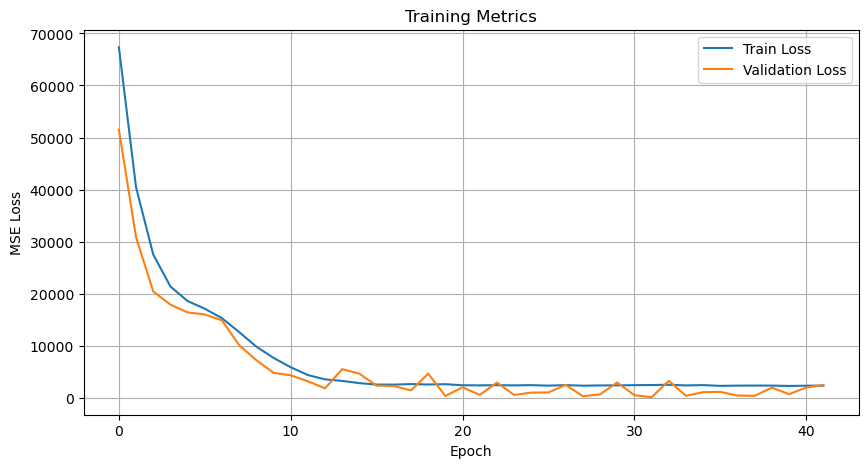


Test Results: MSE = 2540.7459, R2 = 0.9716


In [52]:
small_model = Sequential()
small_model.add(Linear(n_features, 64))
small_model.add(BatchNormalization())
small_model.add(ReLU())
small_model.add(Dropout(p=0.2))
small_model.add(Linear(64, n_targets))

train_losses, val_losses = train_model(
    model=small_model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=100,
    lr=0.01
)

small_model.evaluate()
test_pred = small_model.forward(X_test)
small_test_loss = MSECriterion().forward(test_pred, y_test)
r2 = r2_score(y_test, test_pred)
print(f"\nTest Results: MSE = {small_test_loss:.4f}, R2 = {r2:.4f}")

Epoch 1/100 | Train Loss: 43173.4435 | Val Loss: 24781.6286
Epoch 2/100 | Train Loss: 16924.4063 | Val Loss: 13343.4797
Epoch 3/100 | Train Loss: 11803.1036 | Val Loss: 8029.0557
Epoch 4/100 | Train Loss: 5479.5401 | Val Loss: 2997.6207
Epoch 5/100 | Train Loss: 2389.1017 | Val Loss: 1549.4530
Epoch 6/100 | Train Loss: 1874.2872 | Val Loss: 666.1914
Epoch 7/100 | Train Loss: 1671.3915 | Val Loss: 1264.7539
Epoch 8/100 | Train Loss: 1562.9226 | Val Loss: 410.5798
Epoch 9/100 | Train Loss: 1511.6284 | Val Loss: 3695.0282
Epoch 10/100 | Train Loss: 1419.2743 | Val Loss: 220.1724
Epoch 11/100 | Train Loss: 1506.4126 | Val Loss: 448.8662
Epoch 12/100 | Train Loss: 1559.4092 | Val Loss: 2411.2499
Epoch 13/100 | Train Loss: 1610.7352 | Val Loss: 1768.7646
Epoch 14/100 | Train Loss: 1535.1880 | Val Loss: 4754.7130
Learning rate reduced to 0.001
Epoch 15/100 | Train Loss: 1421.6603 | Val Loss: 508.8091
Epoch 16/100 | Train Loss: 1303.3027 | Val Loss: 1384.6251
Epoch 17/100 | Train Loss: 1363.39

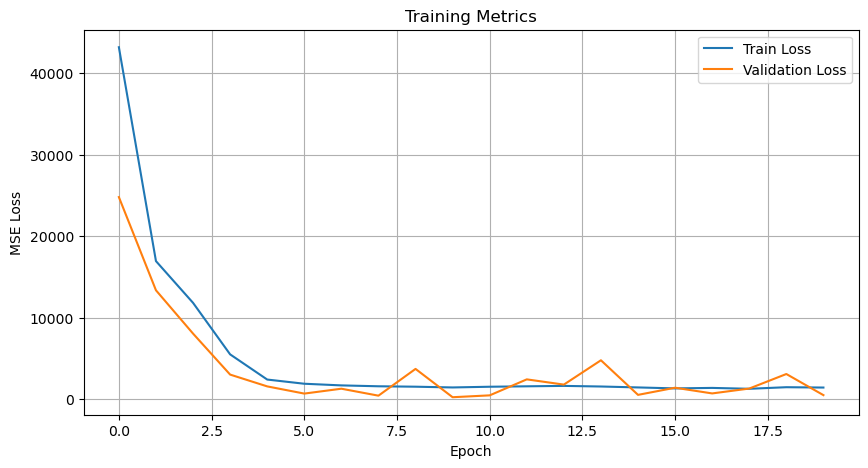


Test Results: MSE = 475.1243, R2 = 0.9946


In [53]:
medium_model = Sequential()
medium_model.add(Linear(n_features, 256))
medium_model.add(BatchNormalization())
medium_model.add(LeakyReLU(slope=0.1))
medium_model.add(Dropout(p=0.3))
medium_model.add(Linear(256, 128))
medium_model.add(BatchNormalization())
medium_model.add(ELU(alpha=1.0))
medium_model.add(Linear(128, n_targets))

train_losses, val_losses = train_model(
    model=medium_model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=100,
    lr=0.01
)

medium_model.evaluate()
test_pred = medium_model.forward(X_test)
medium_test_loss = MSECriterion().forward(test_pred, y_test)
r2 = r2_score(y_test, test_pred)
print(f"\nTest Results: MSE = {medium_test_loss:.4f}, R2 = {r2:.4f}")

Epoch 1/100 | Train Loss: 51672.9716 | Val Loss: 24039.1257
Epoch 2/100 | Train Loss: 24256.6016 | Val Loss: 19153.6611
Epoch 3/100 | Train Loss: 18639.4797 | Val Loss: 16870.4690
Epoch 4/100 | Train Loss: 16104.8107 | Val Loss: 15160.4041
Epoch 5/100 | Train Loss: 13306.8404 | Val Loss: 12503.5400
Epoch 6/100 | Train Loss: 9705.1288 | Val Loss: 7000.0420
Epoch 7/100 | Train Loss: 7845.7936 | Val Loss: 6849.3893
Epoch 8/100 | Train Loss: 7112.5973 | Val Loss: 5127.8761
Epoch 9/100 | Train Loss: 6850.6901 | Val Loss: 6379.1980
Epoch 10/100 | Train Loss: 6690.5357 | Val Loss: 5588.7669
Epoch 11/100 | Train Loss: 5877.8655 | Val Loss: 2790.4464
Epoch 12/100 | Train Loss: 3997.1406 | Val Loss: 4756.1101
Epoch 13/100 | Train Loss: 3005.1761 | Val Loss: 3746.3241
Epoch 14/100 | Train Loss: 2806.8271 | Val Loss: 5107.7774
Epoch 15/100 | Train Loss: 2800.6480 | Val Loss: 1605.8555
Epoch 16/100 | Train Loss: 2746.1983 | Val Loss: 802.5651
Epoch 17/100 | Train Loss: 2770.9013 | Val Loss: 5945.67

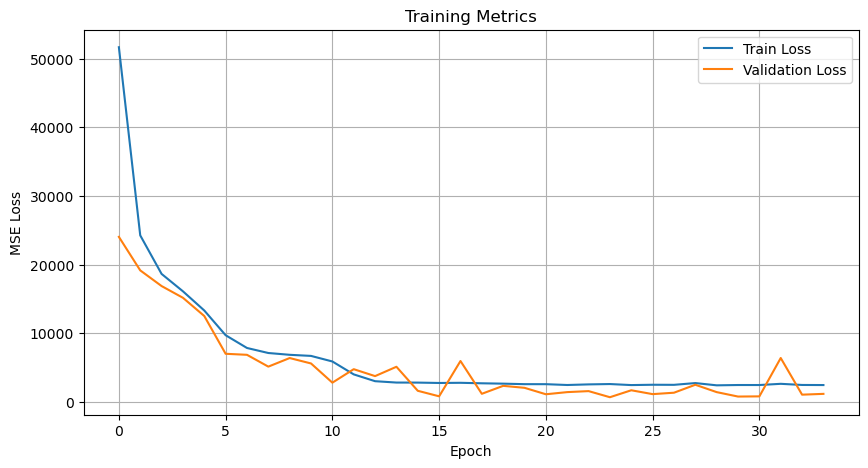


Test Results: MSE = 1168.6282, R2 = 0.9870


In [54]:
large_model = Sequential()
large_model.add(Linear(n_features, 512))
large_model.add(BatchNormalization())
large_model.add(Gelu())
large_model.add(Dropout(p=0.4))
large_model.add(Linear(512, 256))
large_model.add(BatchNormalization())
large_model.add(SoftPlus())
large_model.add(Dropout(p=0.4))
large_model.add(Linear(256, 128))
large_model.add(BatchNormalization())
large_model.add(ReLU())
large_model.add(Linear(128, n_targets))

train_losses, val_losses = train_model(
    model=large_model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=100,
    lr=0.01
)

large_model.evaluate()
test_pred = large_model.forward(X_test)
large_test_loss = MSECriterion().forward(test_pred, y_test)
r2 = r2_score(y_test, test_pred)
print(f"\nTest Results: MSE = {large_test_loss:.4f}, R2 = {r2:.4f}")

In [55]:
variables = {'small model': small_test_loss, 'medium model': medium_test_loss, 'large model': large_test_loss}
best_model = min(variables, key=variables.get)
min_mse = variables[best_model]

print("Лучшая модель:", best_model, "MSE:", min_mse)

Лучшая модель: medium model MSE: 475.12426315376945
